<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/main/C4/W3/ungraded_labs/C4_W3_Lab_1_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Using a Simple RNN for forecasting

In this lab, you will start to use recurrent neural networks (RNNs) to build a forecasting model. In particular, you will:

* build a stacked RNN using `simpleRNN` layers
* use `Lambda` layers to reshape the input and scale the output
* use the Huber loss during training
* use batched data windows to generate model predictions

You will train this on the same synthetic dataset from last week so the initial steps will be the same. Let's begin!

## Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Utilities

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series

def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish
    
    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according 
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))
    
    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """
    
    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern

def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level
    
    return noise

## Generate the Synthetic Data

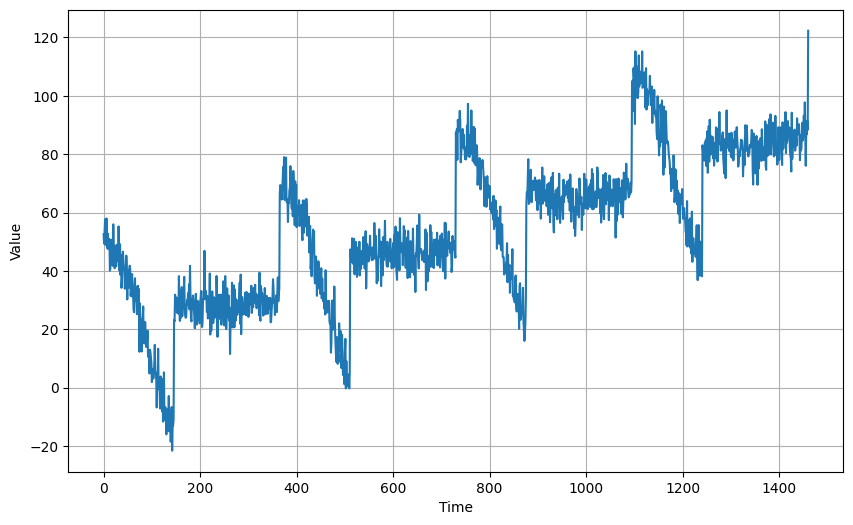

In [3]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

## Split the Dataset

In [4]:
# Define the split time
split_time = 1000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

## Prepare Features and Labels

In [5]:
# Parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [7]:
# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [8]:
# Print shapes of feature and label
for window in dataset.take(1):
  print(f'shape of feature: {window[0].shape}')
  print(f'shape of label: {window[1].shape}')

shape of feature: (32, 20)
shape of label: (32,)


2024-07-08 17:18:31.975569: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Build the Model

Your model is composed mainly of [SimpleRNN](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN) layers. As mentioned in the lectures, this type of RNN simply routes its output back to the input. You will stack two of these layers in your model so the first one should have `return_sequences` set to `True`. 

As mentioned in the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN#call_arguments), `SimpleRNN` layers expect a 3-dimensional tensor input with the shape `[batch, timesteps, feature`]. With that, you need to reshape your window from `(32, 20)` to `(32, 20, 1)`. This means the 20 datapoints in the window will be mapped to 20 timesteps of the RNN. You can do this reshaping in a separate cell but you can also do this within the model itself by using [Lambda](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Lambda) layers. Notice the first layer below. It defines a lambda function that adds a dimension at the last axis of the input. That's exactly the transformation you need. For the `input_shape`, you can specify `None` (like in the lecture video) if you want the model to be more flexible with the number of timesteps. Alternatively, you can set it to `window_size` as shown below if you want to set the `timesteps` dimension to the expected size of your data windows.

Normally, you can just a have a `Dense` layer output as shown in the previous labs. However, you can help the training by scaling up the output to around the same figures as your labels. This will depend on the [activation functions](https://en.wikipedia.org/wiki/Activation_function#Table_of_activation_functions) you used in your model. `SimpleRNN` uses *tanh* by default and that has an output range of `[-1,1]`. You will use another `Lambda()` layer to scale the output by 100 before it adjusts the layer weights. Feel free to remove this layer later after this lab and see what results you get.

In [9]:
# Build the Model
model_tune = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[window_size]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Print the model summary
model_tune.summary()

/Users/civye1/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (None, 20, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 20, 40)         │         1,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 40)             │         3,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            41 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,961 (19.38 KB)

 Trainable params: 4,961 (19.38 KB)

 Non-trainable params: 0 (0.00 B)

## Tune the Learning Rate

You will then tune the learning rate as before. You will define a learning rate schedule that changes this hyperparameter dynamically. You will use the [Huber Loss](https://en.wikipedia.org/wiki/Huber_loss) as your loss function to minimize sensitivity to outliers.

In [10]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model_tune.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model_tune.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 115.8481 - learning_rate: 1.0000e-08
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 111.8898 - learning_rate: 1.1220e-08
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 105.7297 - learning_rate: 1.2589e-08
Epoch 4/100


2024-07-08 17:22:05.807343: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/civye1/anaconda3/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-07-08 17:22:05.915695: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:22:06.001534: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 99.8947 - learning_rate: 1.4125e-08
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 93.4115 - learning_rate: 1.5849e-08
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 84.6005 - learning_rate: 1.7783e-08
Epoch 7/100


2024-07-08 17:22:06.093170: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:22:06.184243: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:22:06.277823: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 75.7291 - learning_rate: 1.9953e-08
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 63.8070 - learning_rate: 2.2387e-08
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 48.8748 - learning_rate: 2.5119e-08
Epoch 10/100


2024-07-08 17:22:06.370148: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:22:06.461168: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:22:06.551965: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 32.2349 - learning_rate: 2.8184e-08
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.9927 - learning_rate: 3.1623e-08
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.5208 - learning_rate: 3.5481e-08
Epoch 13/100


2024-07-08 17:22:06.644270: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:22:06.735359: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:22:06.827079: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15.6486 - learning_rate: 3.9811e-08
Epoch 14/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14.6652 - learning_rate: 4.4668e-08
Epoch 15/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14.2083 - learning_rate: 5.0119e-08
Epoch 16/100


2024-07-08 17:22:06.918908: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:22:07.010328: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:22:07.100975: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12.0297 - learning_rate: 5.6234e-08
Epoch 17/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12.1036 - learning_rate: 6.3096e-08
Epoch 18/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.8944 - learning_rate: 7.0795e-08
Epoch 19/100


2024-07-08 17:22:07.193411: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:22:07.284623: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:22:07.376170: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.4884 - learning_rate: 7.9433e-08
Epoch 20/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.0121 - learning_rate: 8.9125e-08
Epoch 21/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.4355 - learning_rate: 1.0000e-07
Epoch 22/100


2024-07-08 17:22:07.467821: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:22:07.558763: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:22:07.649279: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.3429 - learning_rate: 1.1220e-07
Epoch 23/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.0246 - learning_rate: 1.2589e-07
Epoch 24/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.8850 - learning_rate: 1.4125e-07
Epoch 25/100


2024-07-08 17:22:07.781148: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:22:07.873263: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:22:07.963506: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.8068 - learning_rate: 1.5849e-07
Epoch 26/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.2946 - learning_rate: 1.7783e-07
Epoch 27/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.4260 - learning_rate: 1.9953e-07
Epoch 28/100


2024-07-08 17:22:08.052388: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:22:08.141975: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:22:08.230774: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.4413 - learning_rate: 2.2387e-07
Epoch 29/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.8200 - learning_rate: 2.5119e-07
Epoch 30/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.7648 - learning_rate: 2.8184e-07
Epoch 31/100


2024-07-08 17:22:08.318596: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:22:08.407323: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:22:08.495028: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.7545 - learning_rate: 3.1623e-07
Epoch 32/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.6328 - learning_rate: 3.5481e-07
Epoch 33/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.7773 - learning_rate: 3.9811e-07
Epoch 34/100


2024-07-08 17:22:08.584078: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:22:08.672754: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:22:08.761782: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.1694 - learning_rate: 4.4668e-07
Epoch 35/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.9695 - learning_rate: 5.0119e-07
Epoch 36/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.9321 - learning_rate: 5.6234e-07
Epoch 37/100


2024-07-08 17:22:08.851090: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:22:08.941363: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:22:09.028918: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.2997 - learning_rate: 6.3096e-07
Epoch 38/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.3434 - learning_rate: 7.0795e-07
Epoch 39/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.0983 - learning_rate: 7.9433e-07
Epoch 40/100


2024-07-08 17:22:09.119513: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:22:09.208610: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:22:09.299478: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.3182 - learning_rate: 8.9125e-07
Epoch 41/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.9913 - learning_rate: 1.0000e-06
Epoch 42/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.0048 - learning_rate: 1.1220e-06
Epoch 43/100


2024-07-08 17:22:09.389281: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:22:09.479194: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:22:09.567962: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.5483 - learning_rate: 1.2589e-06
Epoch 44/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.8750 - learning_rate: 1.4125e-06
Epoch 45/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.6756 - learning_rate: 1.5849e-06
Epoch 46/100


2024-07-08 17:22:09.656731: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:22:09.745326: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:22:09.835869: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.5976 - learning_rate: 1.7783e-06
Epoch 47/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.5992 - learning_rate: 1.9953e-06
Epoch 48/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0781 - learning_rate: 2.2387e-06
Epoch 49/100


2024-07-08 17:22:09.940637: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:22:10.031918: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:22:10.121820: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.2554 - learning_rate: 2.5119e-06
Epoch 50/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.9002 - learning_rate: 2.8184e-06
Epoch 51/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.5455 - learning_rate: 3.1623e-06
Epoch 52/100


2024-07-08 17:22:10.210914: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:22:10.299853: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:22:10.388723: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.2297 - learning_rate: 3.5481e-06
Epoch 53/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.5952 - learning_rate: 3.9811e-06
Epoch 54/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.6183 - learning_rate: 4.4668e-06
Epoch 55/100


2024-07-08 17:22:10.510615: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:22:10.602185: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:22:10.693389: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.9353 - learning_rate: 5.0119e-06
Epoch 56/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.8456 - learning_rate: 5.6234e-06
Epoch 57/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.1519 - learning_rate: 6.3096e-06
Epoch 58/100


2024-07-08 17:22:10.782929: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:22:10.875787: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:22:10.965525: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.9648 - learning_rate: 7.0795e-06
Epoch 59/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.1190 - learning_rate: 7.9433e-06
Epoch 60/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.2590 - learning_rate: 8.9125e-06
Epoch 61/100


2024-07-08 17:22:11.055462: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:22:11.144186: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:22:11.232568: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.2947 - learning_rate: 1.0000e-05
Epoch 62/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.4712 - learning_rate: 1.1220e-05
Epoch 63/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.1034 - learning_rate: 1.2589e-05
Epoch 64/100


2024-07-08 17:22:11.321366: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:22:11.410787: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:22:11.499998: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.0737 - learning_rate: 1.4125e-05
Epoch 65/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.4850 - learning_rate: 1.5849e-05
Epoch 66/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.6454 - learning_rate: 1.7783e-05
Epoch 67/100


2024-07-08 17:22:11.589558: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:22:11.678380: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:22:11.767334: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.3997 - learning_rate: 1.9953e-05
Epoch 68/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10.3651 - learning_rate: 2.2387e-05
Epoch 69/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.3897 - learning_rate: 2.5119e-05
Epoch 70/100


2024-07-08 17:22:11.855854: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:22:11.944050: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:22:12.031922: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12.7708 - learning_rate: 2.8184e-05
Epoch 71/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10.5764 - learning_rate: 3.1623e-05
Epoch 72/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.6127 - learning_rate: 3.5481e-05
Epoch 73/100


2024-07-08 17:22:12.125375: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:22:12.215790: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:22:12.306205: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12.7679 - learning_rate: 3.9811e-05
Epoch 74/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.8891 - learning_rate: 4.4668e-05
Epoch 75/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.6456 - learning_rate: 5.0119e-05
Epoch 76/100


2024-07-08 17:22:12.395005: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:22:12.485541: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:22:12.574274: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11.5365 - learning_rate: 5.6234e-05
Epoch 77/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14.9039 - learning_rate: 6.3096e-05
Epoch 78/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13.6357 - learning_rate: 7.0795e-05
Epoch 79/100


2024-07-08 17:22:12.666458: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:22:12.756512: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:22:12.845392: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11.9920 - learning_rate: 7.9433e-05
Epoch 80/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19.3870 - learning_rate: 8.9125e-05
Epoch 81/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.4410 - learning_rate: 1.0000e-04
Epoch 82/100


2024-07-08 17:22:12.934266: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:22:13.023983: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:22:13.112734: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11.2537 - learning_rate: 1.1220e-04
Epoch 83/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12.1574 - learning_rate: 1.2589e-04
Epoch 84/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.9863 - learning_rate: 1.4125e-04
Epoch 85/100


2024-07-08 17:22:13.201922: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:22:13.290435: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:22:13.378853: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19.2015 - learning_rate: 1.5849e-04
Epoch 86/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.1395 - learning_rate: 1.7783e-04
Epoch 87/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.0813 - learning_rate: 1.9953e-04
Epoch 88/100


2024-07-08 17:22:13.466993: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:22:13.555914: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:22:13.644574: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.7378 - learning_rate: 2.2387e-04
Epoch 89/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15.9476 - learning_rate: 2.5119e-04
Epoch 90/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.1967 - learning_rate: 2.8184e-04
Epoch 91/100


2024-07-08 17:22:13.732235: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:22:13.820954: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:22:13.910105: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22.0233 - learning_rate: 3.1623e-04
Epoch 92/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20.7628 - learning_rate: 3.5481e-04
Epoch 93/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.2177 - learning_rate: 3.9811e-04
Epoch 94/100


2024-07-08 17:22:13.999194: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:22:14.087786: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:22:14.176858: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.6964 - learning_rate: 4.4668e-04
Epoch 95/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.3544 - learning_rate: 5.0119e-04
Epoch 96/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.2065 - learning_rate: 5.6234e-04
Epoch 97/100


2024-07-08 17:22:14.265790: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:22:14.354941: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:22:14.444116: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21.3097 - learning_rate: 6.3096e-04
Epoch 98/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19.3138 - learning_rate: 7.0795e-04
Epoch 99/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 25.2354 - learning_rate: 7.9433e-04
Epoch 100/100


2024-07-08 17:22:14.533070: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:22:14.621896: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:22:14.710907: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 103.2716 - learning_rate: 8.9125e-04


2024-07-08 17:22:14.799658: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


You can visualize the results and pick an optimal learning rate.

(1e-08, 0.001, 0.0, 50.0)

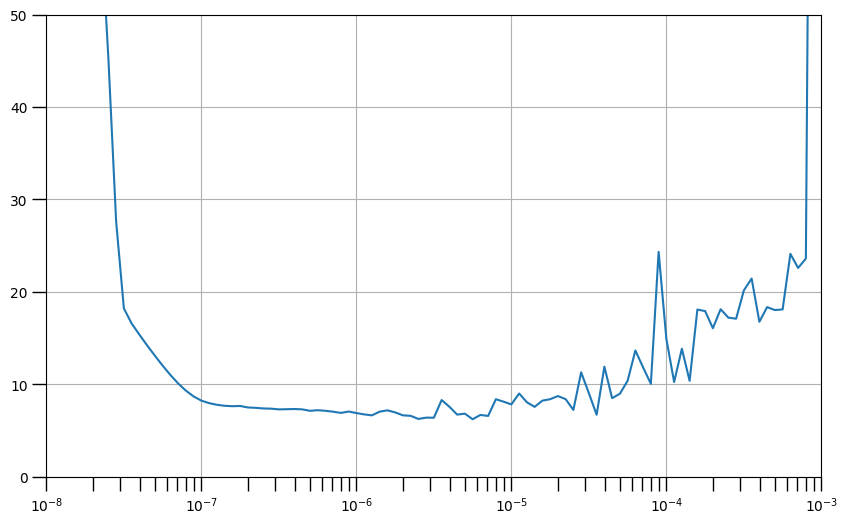

In [11]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 50])

You can change the boundaries of the graph if you want to zoom in. The cell below chooses a narrower range so you can see more clearly where the graph becomes unstable.

(1e-07, 0.0001, 0.0, 20.0)

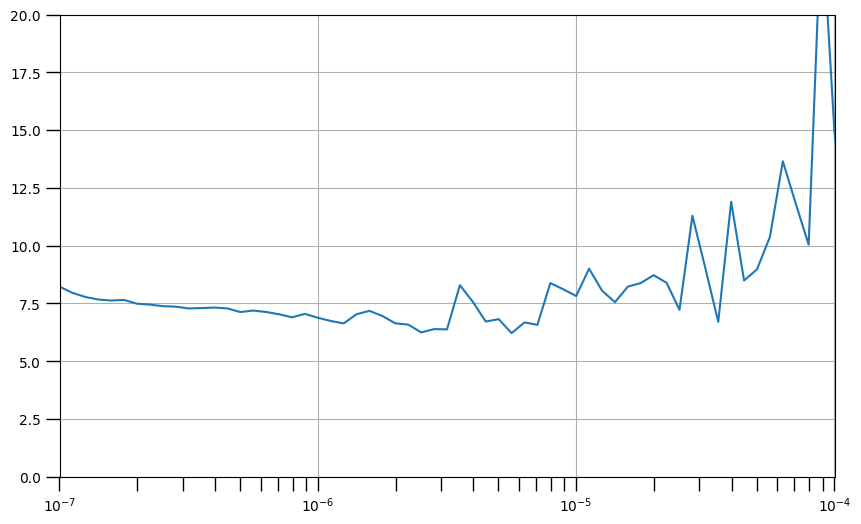

In [12]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-7, 1e-4, 0, 20])

## Train the Model

You can then declare the model again and train with the learning rate you picked. It is set to `1e-6`by default but feel free to change it.

In [13]:
# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[window_size]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Set the learning rate
learning_rate = 1e-6

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(dataset,epochs=100)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 111.6772 - mae: 112.1769
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20.6860 - mae: 21.1811
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13.3778 - mae: 13.8706
Epoch 4/100


2024-07-08 17:29:25.820935: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:29:25.911900: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:29:25.999587: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11.2364 - mae: 11.7248
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10.7130 - mae: 11.1955
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.3842 - mae: 8.8721
Epoch 7/100


2024-07-08 17:29:26.090952: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:29:26.181906: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:29:26.271749: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.1558 - mae: 8.6402
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.1797 - mae: 8.6651
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.9417 - mae: 8.4256
Epoch 10/100


2024-07-08 17:29:26.364754: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:29:26.458063: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:29:26.550088: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.5025 - mae: 7.9873
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.8564 - mae: 7.3367
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.3567 - mae: 7.8318  
Epoch 13/100


2024-07-08 17:29:26.641962: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:29:26.734128: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:29:26.824882: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.0119 - mae: 7.4932  
Epoch 14/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.4735 - mae: 7.9523
Epoch 15/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.8071 - mae: 7.2913
Epoch 16/100


2024-07-08 17:29:26.916921: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:29:27.008360: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:29:27.099225: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.7914 - mae: 7.2729
Epoch 17/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.6947 - mae: 7.1752
Epoch 18/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.2948 - mae: 7.7823
Epoch 19/100


2024-07-08 17:29:27.190604: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:29:27.282577: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:29:27.373979: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.1291 - mae: 7.6093
Epoch 20/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.6555 - mae: 7.1369
Epoch 21/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.3691 - mae: 6.8527
Epoch 22/100


2024-07-08 17:29:27.465660: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:29:27.556940: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:29:27.647576: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.7811 - mae: 6.2587
Epoch 23/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.6562 - mae: 7.1379
Epoch 24/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.9647 - mae: 6.4416
Epoch 25/100


2024-07-08 17:29:27.739720: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:29:27.829474: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:29:27.919513: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.7884 - mae: 6.2696
Epoch 26/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0629 - mae: 6.5433
Epoch 27/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.9654 - mae: 6.4487
Epoch 28/100


2024-07-08 17:29:28.008513: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:29:28.099990: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:29:28.189745: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0973 - mae: 6.5710
Epoch 29/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.8438 - mae: 7.3260
Epoch 30/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.2810 - mae: 6.7620
Epoch 31/100


2024-07-08 17:29:28.278998: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:29:28.367620: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:29:28.457621: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.9012 - mae: 7.3865
Epoch 32/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.5528 - mae: 7.0357
Epoch 33/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.1794 - mae: 6.6595
Epoch 34/100


2024-07-08 17:29:28.546675: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:29:28.636230: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:29:28.725223: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.7642 - mae: 7.2463
Epoch 35/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0874 - mae: 6.5648
Epoch 36/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.6372 - mae: 7.1243
Epoch 37/100


2024-07-08 17:29:28.814104: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:29:28.903787: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:29:28.993386: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.8410 - mae: 6.3204
Epoch 38/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.3145 - mae: 6.7961
Epoch 39/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 8.7773 - mae: 9.2659

2024-07-08 17:29:29.082747: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:29:29.214251: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.8472 - mae: 6.3268
Epoch 40/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.4709 - mae: 6.9495
Epoch 41/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.5063 - mae: 5.9883
Epoch 42/100


2024-07-08 17:29:29.308355: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:29:29.400195: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:29:29.489802: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.2326 - mae: 6.7156
Epoch 43/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.3515 - mae: 6.8299
Epoch 44/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.9800 - mae: 6.4638
Epoch 45/100


2024-07-08 17:29:29.587395: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:29:29.681660: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:29:29.772886: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.7522 - mae: 6.2332
Epoch 46/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.5969 - mae: 6.0750
Epoch 47/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.7639 - mae: 6.2403
Epoch 48/100


2024-07-08 17:29:29.863417: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:29:29.961511: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:29:30.062191: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.4081 - mae: 5.8874
Epoch 49/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.5034 - mae: 5.9831
Epoch 50/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.5364 - mae: 6.0168
Epoch 51/100


2024-07-08 17:29:30.152802: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:29:30.243474: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:29:30.333639: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.7958 - mae: 6.2799
Epoch 52/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.9817 - mae: 6.4637
Epoch 53/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.3128 - mae: 6.7971
Epoch 54/100


2024-07-08 17:29:30.422991: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:29:30.512694: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:29:30.602487: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.3627 - mae: 6.8449
Epoch 55/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.8439 - mae: 6.3231
Epoch 56/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.6845 - mae: 6.1621
Epoch 57/100


2024-07-08 17:29:30.702346: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:29:30.792122: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:29:30.881841: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.8373 - mae: 6.3199
Epoch 58/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.4935 - mae: 5.9688
Epoch 59/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.4668 - mae: 5.9416
Epoch 60/100


2024-07-08 17:29:30.971192: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:29:31.060789: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:29:31.150864: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.6379 - mae: 6.1159
Epoch 61/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.9018 - mae: 6.3802
Epoch 62/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.2974 - mae: 5.7761
Epoch 63/100


2024-07-08 17:29:31.239772: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:29:31.329116: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:29:31.418055: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.6584 - mae: 6.1401
Epoch 64/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.4368 - mae: 5.9147
Epoch 65/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.3777 - mae: 5.8547
Epoch 66/100


2024-07-08 17:29:31.507151: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:29:31.596175: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:29:31.684866: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.4090 - mae: 5.8888
Epoch 67/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.6949 - mae: 6.1756
Epoch 68/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0026 - mae: 6.4845
Epoch 69/100


2024-07-08 17:29:31.773662: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:29:31.864012: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:29:31.954313: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.5194 - mae: 6.0006
Epoch 70/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.6728 - mae: 6.1497
Epoch 71/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.3287 - mae: 5.8081
Epoch 72/100


2024-07-08 17:29:32.043950: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:29:32.133410: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:29:32.223165: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.1109 - mae: 6.5888
Epoch 73/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.4102 - mae: 5.8862
Epoch 74/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.2509 - mae: 5.7313
Epoch 75/100


2024-07-08 17:29:32.311296: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:29:32.401558: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:29:32.491263: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.4868 - mae: 5.9622
Epoch 76/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.4280 - mae: 5.9000
Epoch 77/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.4448 - mae: 5.9163
Epoch 78/100


2024-07-08 17:29:32.580441: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:29:32.670369: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:29:32.760256: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9509 - mae: 5.4254
Epoch 79/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.3670 - mae: 5.8463
Epoch 80/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.3340 - mae: 5.8153
Epoch 81/100


2024-07-08 17:29:32.849783: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:29:32.945243: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:29:33.036294: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.3776 - mae: 5.8601
Epoch 82/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.1470 - mae: 5.6228
Epoch 83/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.7961 - mae: 6.2788
Epoch 84/100


2024-07-08 17:29:33.127416: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:29:33.217367: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:29:33.306679: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.2208 - mae: 5.6985
Epoch 85/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.4970 - mae: 5.9760
Epoch 86/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.0248 - mae: 5.4988
Epoch 87/100


2024-07-08 17:29:33.396106: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:29:33.486644: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:29:33.576363: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.5369 - mae: 6.0211
Epoch 88/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.1757 - mae: 5.6530
Epoch 89/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.2594 - mae: 5.7390
Epoch 90/100


2024-07-08 17:29:33.666043: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:29:33.755959: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:29:33.845744: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.3030 - mae: 5.7851
Epoch 91/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.5723 - mae: 6.0462
Epoch 92/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9911 - mae: 5.4653
Epoch 93/100


2024-07-08 17:29:33.935187: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:29:34.024778: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:29:34.114205: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.1403 - mae: 5.6193
Epoch 94/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.2298 - mae: 5.7044
Epoch 95/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.1629 - mae: 5.6439
Epoch 96/100


2024-07-08 17:29:34.203989: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:29:34.292847: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:29:34.382573: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.2189 - mae: 5.6900
Epoch 97/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.3916 - mae: 5.8693
Epoch 98/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.3403 - mae: 5.8237
Epoch 99/100


2024-07-08 17:29:34.472416: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:29:34.562110: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:29:34.651272: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.2863 - mae: 5.7607
Epoch 100/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.2152 - mae: 5.6950


2024-07-08 17:29:34.741120: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-08 17:29:34.832379: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


## Model Prediction

Now it's time to generate the model predictions for the validation set time range. The model is a lot bigger than the ones you used before and the sequential nature of RNNs (i.e. inputs go through a series of time steps as opposed to parallel processing) can make predictions a bit slow. You can observe this when using the code you ran in the previous lab. This will take about a minute to complete.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


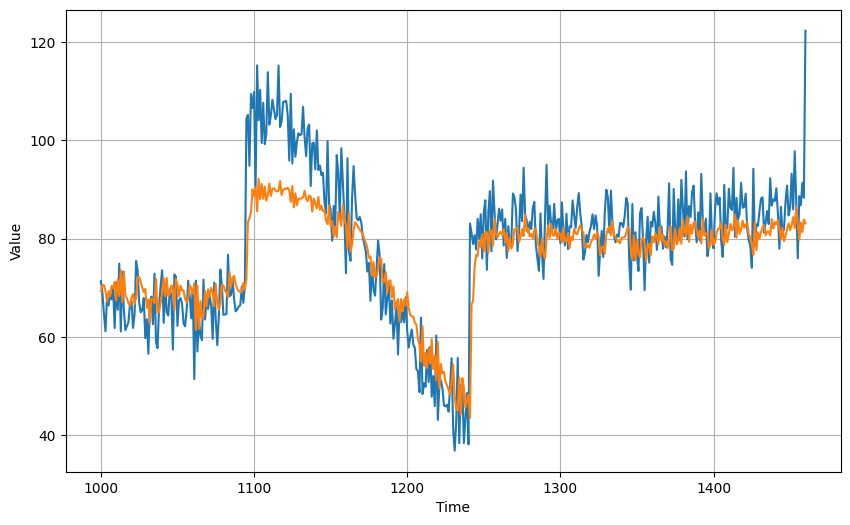

In [14]:
# Initialize a list
forecast = []

# Reduce the original series
forecast_series = series[split_time - window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
  forecast.append(model.predict(forecast_series[time:time + window_size][np.newaxis]))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

You can optimize this step by leveraging Tensorflow models' capability to process batches. Instead of running the for-loop above which processes a single window at a time, you can pass in an entire batch of windows and let the model process that in parallel.

The function below does just that. You will notice that it almost mirrors the `windowed_dataset()` function but it does not shuffle the windows. That's because we want the output to be in its proper sequence so we can compare it properly to the validation set.

In [15]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

You can run the function below to use the function. Notice that the predictions are generated almost instantly.

*Note: You might notice that the first line slices the `series` at `split_time - window_size:-1` which is a bit different from the slower for-loop code. That is because we want the model to have its last prediction to align with the last point of the validation set (i.e. `t=1460`). You were able to do that with the slower for-loop code by specifying the for-loop's `range()`. With the more efficient function above, you don't have that mechanism so you instead just remove the last point when slicing the `series`. If you don't, then the function will generate a prediction at `t=1461` which is outside the validation set range.*

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


2024-07-08 17:40:41.044178: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


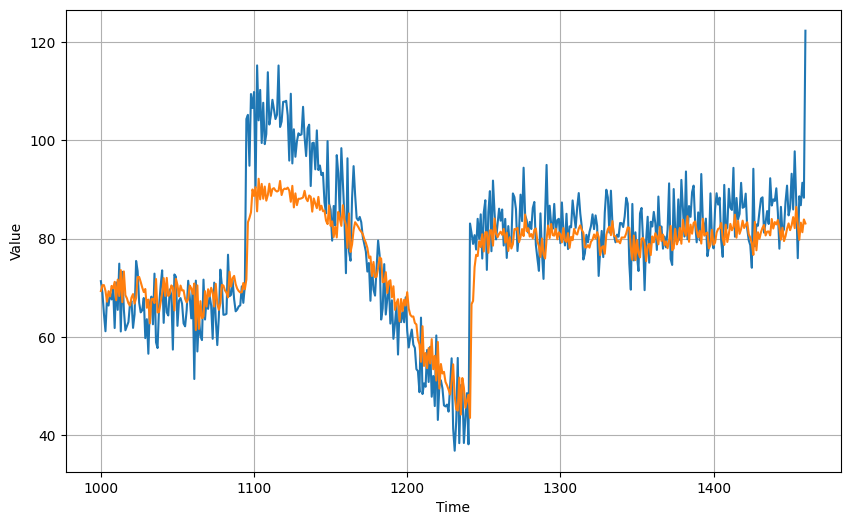

In [16]:
# Reduce the original series
forecast_series = series[split_time - window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

You can then compute the MSE and MAE. You can compare the results here when using other RNN architectures which you'll do in the next lab.

In [17]:
# Compute the MSE and MAE
print(tf.keras.metrics.mse(x_valid, results).numpy())
print(tf.keras.metrics.mae(x_valid, results).numpy())

69.90485
6.2086024
